In [9]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [10]:
rng = default_rng(seed=42)

In [4]:
l = np.arange(-180,180,1)
b = np.arange(-90,90,1)
l_grid, b_grid = np.meshgrid(l, b)
c = SkyCoord(l=l_grid*u.degree, b=b_grid*u.degree, frame='galactic')
l_arr = l_grid.flatten()
b_arr = b_grid.flatten()

#the map is in (ra,dec) so we need to convert:
ra = c.icrs.ra.degree.flatten() 
dec = c.icrs.dec.degree.flatten() 

In [5]:
def plot_completeness(l, b, completeness, title=None):
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.scatter( l, b, c=completeness , vmin=0.8, vmax=1,s=1)
    plt.colorbar(label='completeness')
    plt.xlim(180,-180)
    plt.ylim(-90, 90)
    plt.xlabel('l (degrees)')
    plt.ylabel('b (degrees)')
    plt.show()

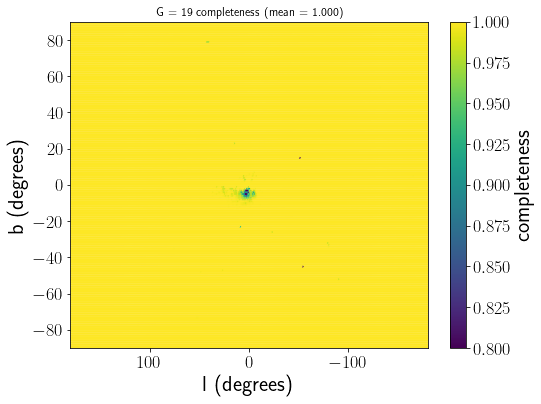

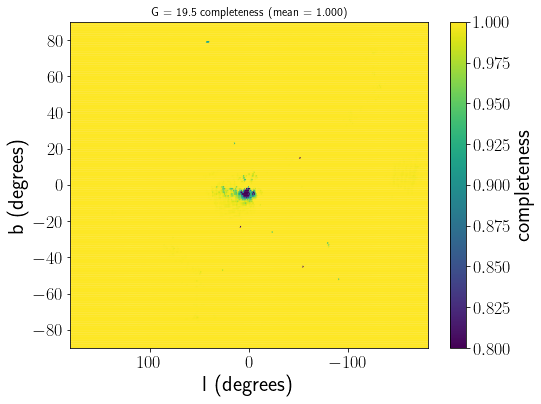

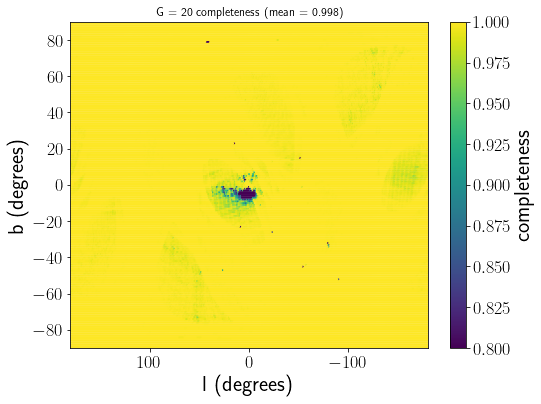

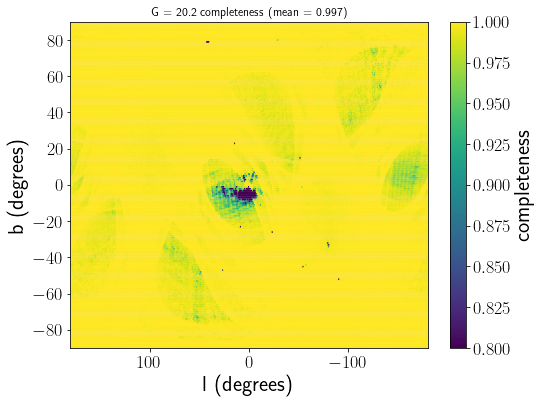

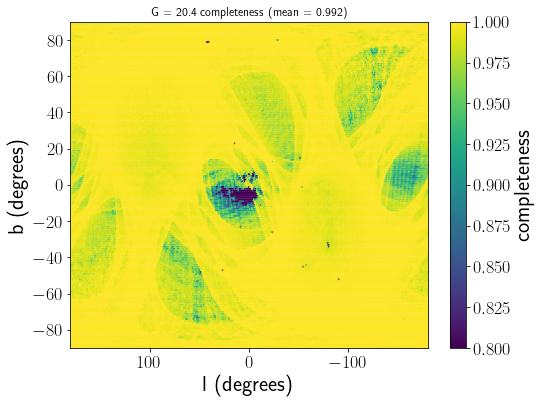

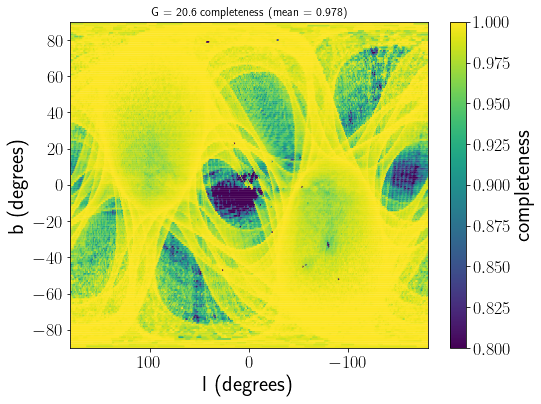

In [6]:
gmag_lims = [19, 19.5, 20, 20.2, 20.4, 20.6]
for gmag in gmag_lims:
    completeness = utils.get_completeness(ra, dec, gmag)
    title = f'G = {gmag} completeness (mean = {np.mean(completeness):.3f})'
    plot_completeness(l_arr, b_arr, completeness, title=title)

Uniform random on sphere (idk if l and b are uniform?? maybe not?)

In [15]:
N_sphere = int(1e6)
ra_sphere, dec_sphere = utils.random_ra_dec_on_sphere(rng, N_sphere)

NPIX: 49152


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


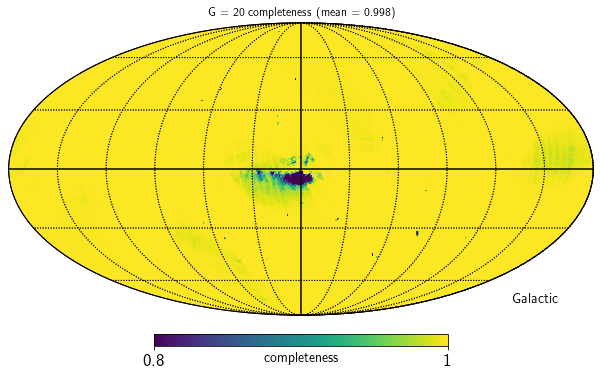

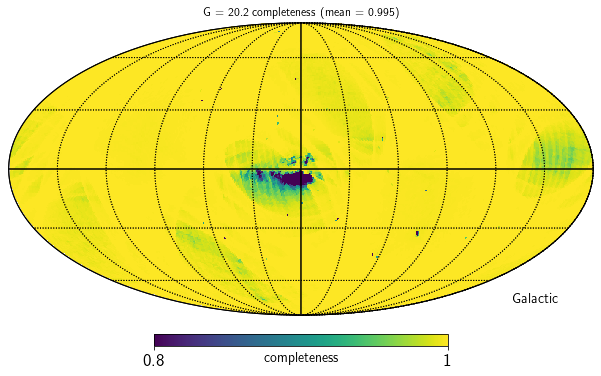

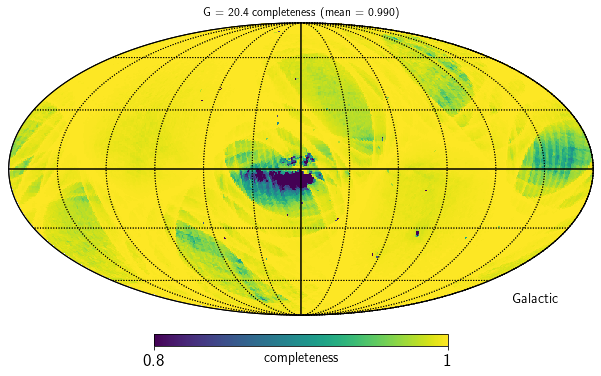

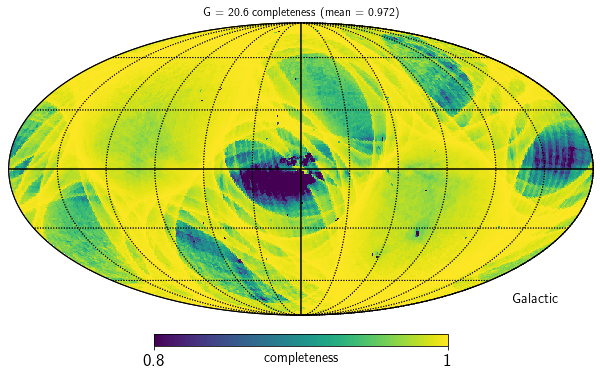

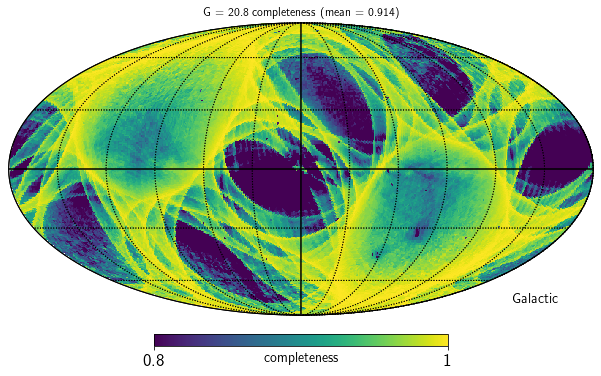

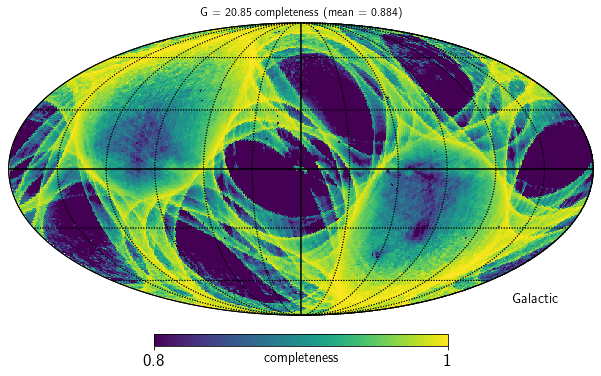

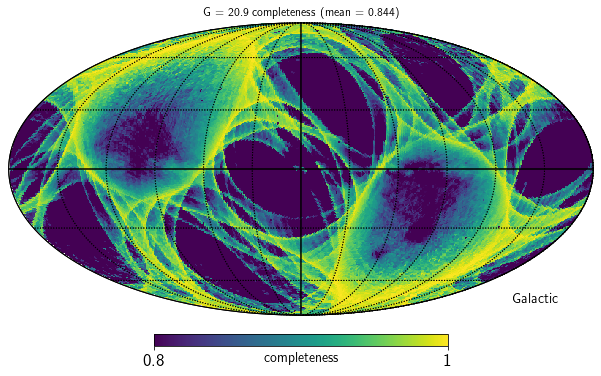

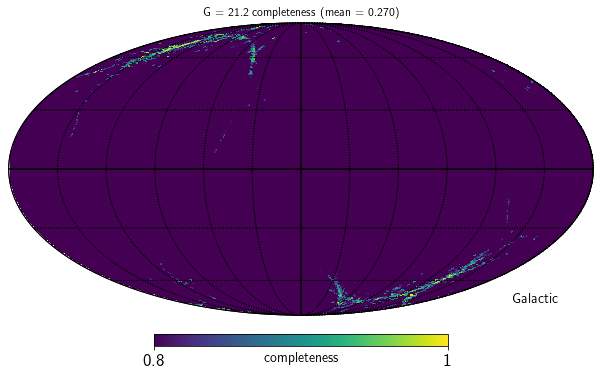

In [205]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print(f"NPIX: {NPIX}")
gmag_lims = [20, 20.2, 20.4, 20.6, 20.8, 20.85, 20.9, 21.2]
for gmag in gmag_lims:
    gmags = np.full(len(ra_sphere), gmag)
    completeness = utils.get_completeness(ra_sphere, dec_sphere, gmags)
    title = f'G = {gmag} completeness (mean = {np.mean(completeness):.3f})'
    map_comp, _ = maps.get_map(64, ra_sphere, dec_sphere, quantity=completeness, func_name='mean',
            null_val=np.nan)

    hp.mollview(map_comp, title=title, unit=r"completeness",
                cmap='viridis', coord=['C', 'G'], min=0.8, max=1)
    hp.graticule()
    #I = np.random.uniform(size=len(ra_sphere)) < completeness
    #map_n, _ = maps.get_map(64, ra_sphere[I], dec_sphere[I], func_name='count',
    #        null_val=0)
    #hp.mollview(map_n, title=title, unit=r"completeness",
    #            cmap='viridis', coord=['C', 'G'])#, min=0, max=1)
    hp.graticule()

## Load in data

In [174]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [175]:
fn_gaia = '../data/gaia_spz_kNN.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
ra_data, dec_data, gmag_data = tab_gaia['ra'], tab_gaia['dec'], tab_gaia['phot_g_mean_mag']
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [176]:
map_nqso_data, pixel_indices_data = maps.get_map(NSIDE, ra_data, dec_data, null_val=0)

0.0 180.0 -180.0 180.0


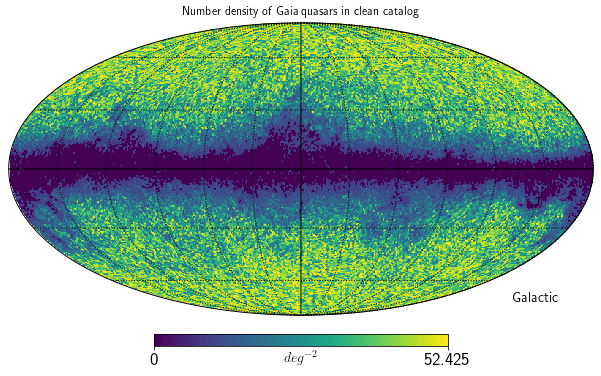

In [177]:
hp.mollview(
    map_nqso_data/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Galactic plane mask:

In [181]:
b_max = 10
mask_func_args = [b_max]
mask_func = masks.galactic_plane_mask
ra_data_plane, dec_data_plane = masks.subsample_by_mask(NSIDE, ra_data, dec_data, mask_func, mask_func_args)

Applied mask, kept 0.988 of sources


In [182]:
map_nqso_data_plane, pixel_indices_data_plane = maps.get_map(NSIDE, ra_data_plane, dec_data_plane, null_val=0)

0.0 180.0 -180.0 180.0


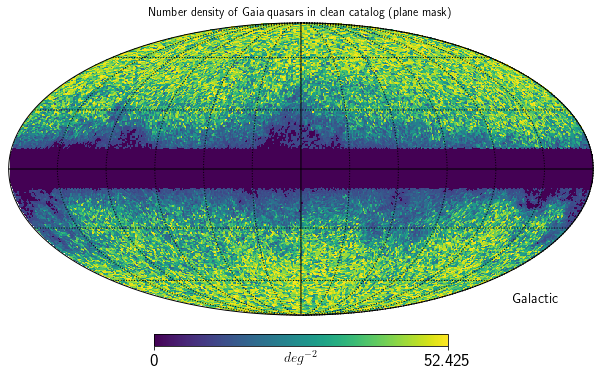

In [183]:
hp.mollview(
    map_nqso_data_plane/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog (plane mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Add magellanic cloud mask:

In [184]:
mask_func = masks.magellanic_clouds_mask
mask_func_args = []
ra_data_planemcs, dec_data_planemcs = masks.subsample_by_mask(NSIDE, ra_data_plane, dec_data_plane, 
                                                              mask_func, mask_func_args)

Applied mask, kept 0.997 of sources


In [185]:
map_nqso_data_planemcs, pixel_indices_data_planemcs = maps.get_map(NSIDE, ra_data_planemcs, dec_data_planemcs, 
                                                                    null_val=0)

0.0 180.0 -180.0 180.0


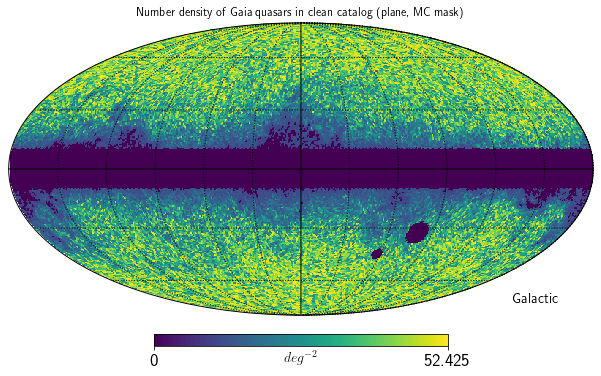

In [186]:
hp.mollview(
    map_nqso_data_planemcs/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog (plane, MC mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Add dust mask (Av cut)

In [206]:
rng = default_rng(seed=42)

In [208]:
mask_func = masks.galactic_dust_mask
Av_max = 0.2
R = 3.1
fn_dustmap = '../data/dustmap_Avmean_NSIDE64.npy'
mask_func_args = [Av_max, R, fn_dustmap]
ra_data_planemcsAv, dec_data_planemcsAv = masks.subsample_by_mask(NSIDE, ra_data_planemcs, dec_data_planemcs, 
                                                              mask_func, mask_func_args)

Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.718 of sources


In [209]:
map_nqso_data_planemcsAv, pixel_indices_data_planemcsAv = maps.get_map(NSIDE, ra_data_planemcsAv, dec_data_planemcsAv, 
                                                                    null_val=0)

0.0 180.0 -180.0 180.0


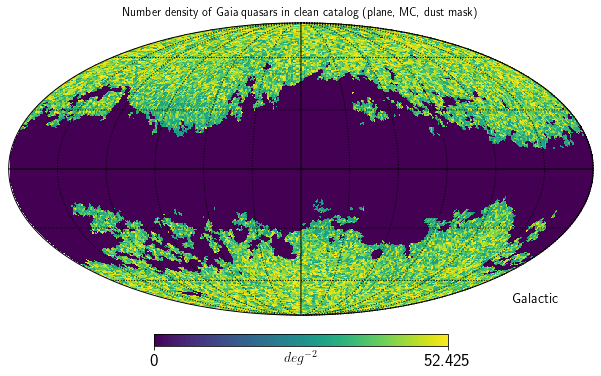

In [210]:
hp.mollview(
    map_nqso_data_planemcsAv/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog (plane, MC, dust mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### NSIDE=8 dust

In [196]:
import masks

In [200]:
mask_func = masks.galactic_dust_mask
Av_max = 0.2
R = 3.1
fn_dustmap = '../data/dustmap_Avmean_NSIDE8.npy'
mask_func_args = [Av_max, R, fn_dustmap]
ra_data_planemcsAv8, dec_data_planemcsAv8 = masks.subsample_by_mask(8, ra_data_planemcs, dec_data_planemcs, 
                                                              mask_func, mask_func_args)

Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE8.npy
Applied mask, kept 0.681 of sources


In [201]:
map_nqso_data_planemcsAv8, pixel_indices_data_planemcsAv8 = maps.get_map(NSIDE, ra_data_planemcsAv8, dec_data_planemcsAv8, 
                                                                    null_val=0)

0.0 180.0 -180.0 180.0


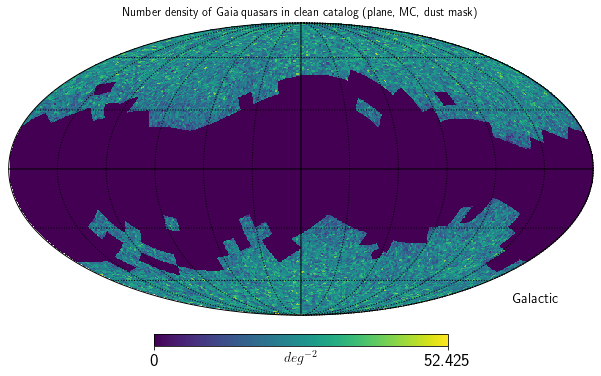

In [202]:
hp.mollview(
    map_nqso_data_planemcsAv8/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog (plane, MC, dust mask)",
    unit=r"$deg^{-2}$",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

## w(theta) random factor test

Test effect of random x factor (on dust, completeness, plane mask version)

In [148]:
nbins = 12
theta_edges_log = np.logspace(-1, 1, nbins + 1)
theta_avg_log = 10**(0.5*(np.log10(theta_edges_log[:-1]) + np.log10(theta_edges_log[1:])))
print(theta_edges_log)

[ 0.1         0.14677993  0.21544347  0.31622777  0.46415888  0.68129207
  1.          1.46779927  2.15443469  3.16227766  4.64158883  6.81292069
 10.        ]


In [50]:
wthetas_plane_facchecks_log = []
facs_rand = [1, 3, 5]
for fac_rand in facs_rand:
    tab_rdustplane_facrand = utils.load_table(f'../data/randoms/random_dust64_maskplane_{fac_rand}x.fits')
    wtheta_plane_facchecks_log = correlations.compute_wtheta(theta_edges_log, ra_data_plane, dec_data_plane,
                                                tab_rdustplane_facrand['ra'], tab_rdustplane_facrand['dec'])
    wthetas_plane_facchecks_log.append(wtheta_plane_facchecks_log)

Time: 6.5194 s
Time: 13.7686 s
Time: 7.2055 s
Time: 7.7178 s
Time: 46.0018 s
Time: 65.0470 s
Time: 7.9475 s
Time: 77.3632 s
Time: 190.1923 s


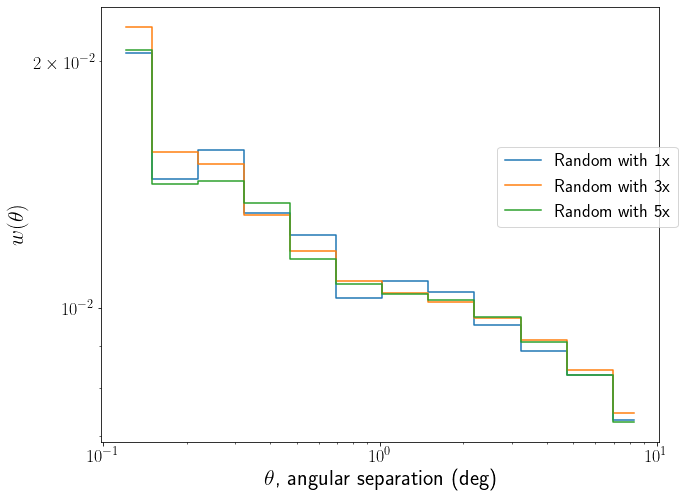

In [52]:
plt.figure(figsize=(10,8))
for i, fac_rand in enumerate(facs_rand):
    plt.step(theta_avg_log, wthetas_plane_facchecks_log[i], where='mid', label=f'Random with {fac_rand}x')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
plt.yscale('log')
plt.axhline(0, color='grey', lw=0.8)
plt.legend(bbox_to_anchor=(1.05, 0.7))

Great - a low random factor just makes it noisier but the overall slope is the same, so we can use 1x to test slope-related things.

## Effect of completeness

In [155]:
fac_rand = 1

In [156]:
tab_rcomp208 = utils.load_table(f'../data/randoms/random_completeness20.8_maskplane20_{fac_rand}x.fits')

In [157]:
map_nqso_rcomp208, _ = maps.get_map(64, tab_rcomp208['ra'], tab_rcomp208['dec'], func_name='count', null_val=0)

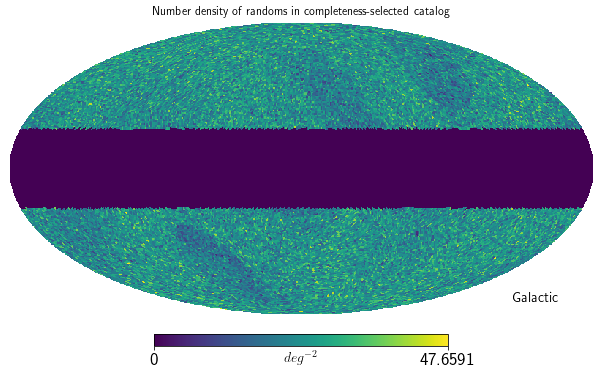

In [158]:
hp.mollview(
    map_nqso_rcomp208/area_per_pixel,
    title=rf"Number density of randoms in completeness-selected catalog",
    unit=r"$deg^{-2}$",
    cmap='viridis',
    coord=['C', 'G'],
    #min=300,
    #max=10,
    #max=20
)
#hp.graticule()

In [159]:
tab_runi = utils.load_table(f'../data/randoms/random_maskplane20_{fac_rand}x.fits')

In [160]:
map_nqso_runi, _ = maps.get_map(64, tab_runi['ra'], tab_runi['dec'], func_name='count', null_val=0)

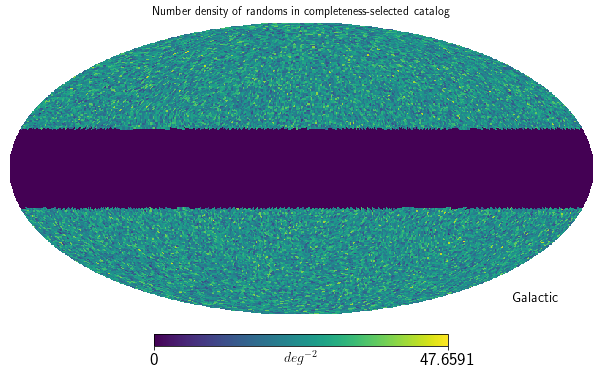

In [161]:
hp.mollview(
    map_nqso_runi/area_per_pixel,
    title=rf"Number density of randoms in completeness-selected catalog",
    unit=r"$deg^{-2}$",
    cmap='viridis',
    coord=['C', 'G'],
    #min=300,
    #max=10,
    #max=20
)
#hp.graticule()

In [162]:
tab_runi41 = utils.load_table(f'../data/randoms/random_seed41_maskplane20_{fac_rand}x.fits')

In [163]:
wtheta_rcomp208_log = correlations.compute_wtheta(theta_edges_log, tab_rcomp208['ra'], tab_rcomp208['dec'],
                                            tab_runi['ra'], tab_runi['dec'])

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 6.9108 s
Time: 14.5618 s
Time: 7.3452 s


In [164]:
wtheta_rseed41_log = correlations.compute_wtheta(theta_edges_log, tab_runi41['ra'], tab_runi41['dec'],
                                            tab_runi['ra'], tab_runi['dec'])

Time: 7.9299 s
Time: 19.9259 s
Time: 11.6276 s


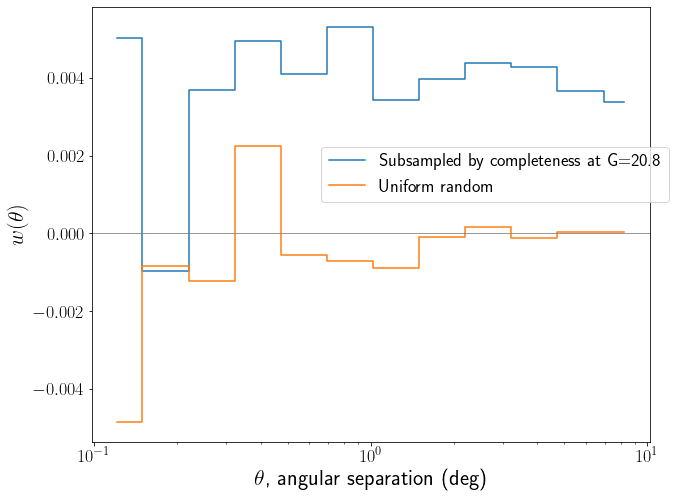

In [165]:
plt.figure(figsize=(10,8))
plt.step(theta_avg_log, wtheta_rcomp208_log, where='mid', label=f'Subsampled by completeness at G=20.8')
plt.step(theta_avg_log, wtheta_rseed41_log, where='mid', label=f'Uniform random')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
#plt.yscale('log')
plt.axhline(0, color='grey', lw=0.8)
plt.legend(bbox_to_anchor=(1.05, 0.7))

## Load in randoms

In [64]:
fac_rand = 1

### Uniform random

In [214]:
tab_r = utils.load_table(f'../data/randoms/random_{fac_rand}x.fits')

In [66]:
map_nqso_r, pixel_indices_r = maps.get_map(NSIDE, tab_r['ra'], tab_r['dec'], null_val=0)

0.0 180.0 -180.0 180.0


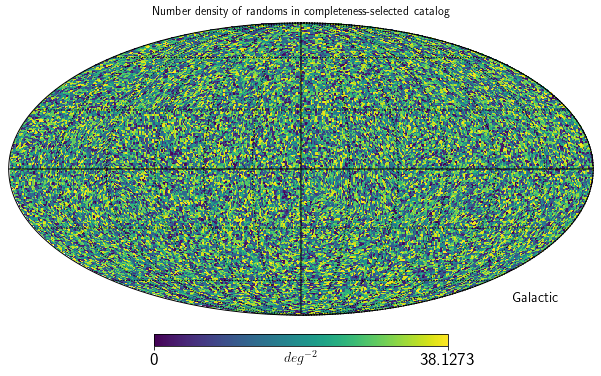

In [67]:
hp.mollview(
    map_nqso_r/area_per_pixel,
    title=rf"Number density of randoms in completeness-selected catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Dust

In [68]:
tab_rcompdust = utils.load_table(f'../data/randoms/random_dust64_{fac_rand}x.fits')

In [69]:
map_nqso_rdust, pixel_indices_rdust = maps.get_map(NSIDE, tab_rdust['ra'], tab_rdust['dec'], 
                                                               null_val=0)

0.0 180.0 -180.0 180.0


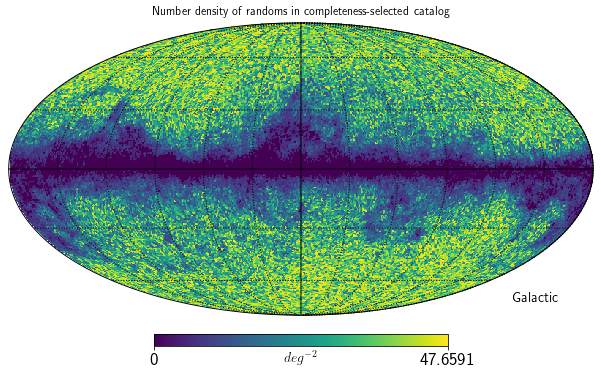

In [70]:
hp.mollview(
    map_nqso_rdust/area_per_pixel,
    title=rf"Number density of randoms in completeness-selected catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Completeness + dust + mask galactic plane

In [83]:
tab_rdustplane = utils.load_table(f'../data/randoms/random_dust64_maskplane_{fac_rand}x.fits')

In [84]:
map_nqso_rcompdustplane, _ = maps.get_map(NSIDE, tab_rcompdustplane['ra'], tab_rcompdustplane['dec'], null_val=0)

0.0 180.0 -180.0 180.0


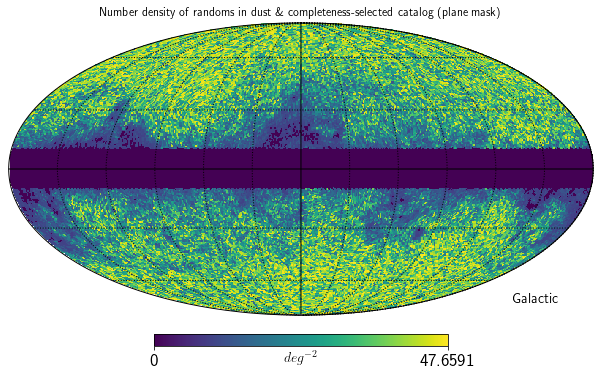

In [85]:
hp.mollview(
    map_nqso_rcompdustplane/area_per_pixel,
    title=rf"Number density of randoms in dust \& completeness-selected catalog (plane mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Completeness + dust + mask galactic plane + mask MCs

In [97]:
tab_rcompdustplanemcs = utils.load_table(f'../data/randoms/random_dust_completeness_maskplane_maskmcs_{fac_rand}x.fits')

In [98]:
map_nqso_rcompdustplanemcs, _ = maps.get_map(NSIDE, tab_rcompdustplanemcs['ra'], tab_rcompdustplanemcs['dec'], 
                                              null_val=0)

0.0 180.0 -180.0 180.0


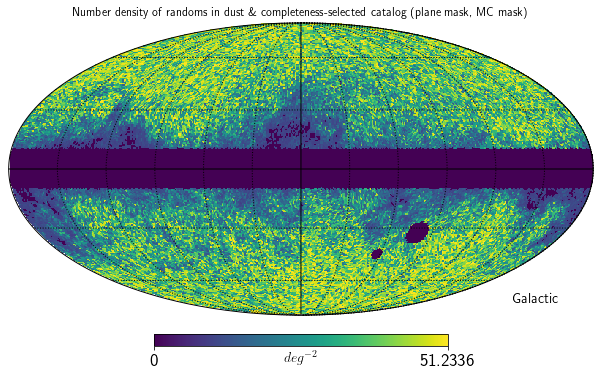

In [111]:
hp.mollview(
    map_nqso_rcompdustplanemcs/area_per_pixel,
    title=rf"Number density of randoms in dust \& completeness-selected catalog (plane mask, MC mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Completeness + dust + mask galactic plane + mask MCs + mask dust

In [112]:
tab_rcompdustplanemcsAv = utils.load_table(f'../data/randoms/random_dust_completeness_maskplane_maskmcs_maskdust_{fac_rand}x.fits')

In [113]:
map_nqso_rcompdustplanemcsAv, _ = maps.get_map(NSIDE, tab_rcompdustplanemcsAv['ra'], tab_rcompdustplanemcsAv['dec'], 
                                              null_val=0)

0.0 180.0 -180.0 180.0


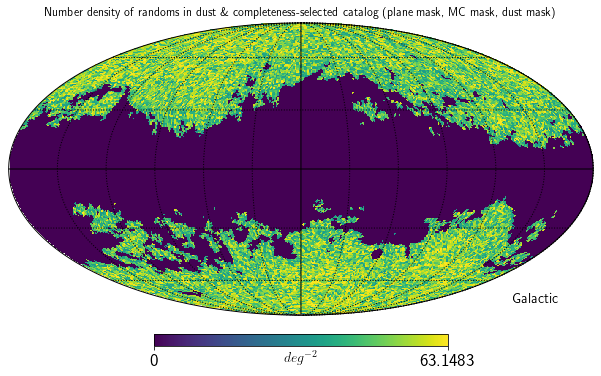

In [114]:
hp.mollview(
    map_nqso_rcompdustplanemcsAv/area_per_pixel,
    title=rf"Number density of randoms in dust \& completeness-selected catalog (plane mask, MC mask, dust mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

### Dust map with NSIDE=8

In [211]:
tab_rcompdust8planemcsAv = utils.load_table('../data/randoms/random_dustNSIDE8_maskplane_maskmcs_maskdust0.2_1x.fits')

In [212]:
map_nqso_rcompdust8planemcsAv, _ = maps.get_map(NSIDE, tab_rcompdust8planemcsAv['ra'], tab_rcompdust8planemcsAv['dec'], 
                                              null_val=0)

0.0 180.0 -180.0 180.0


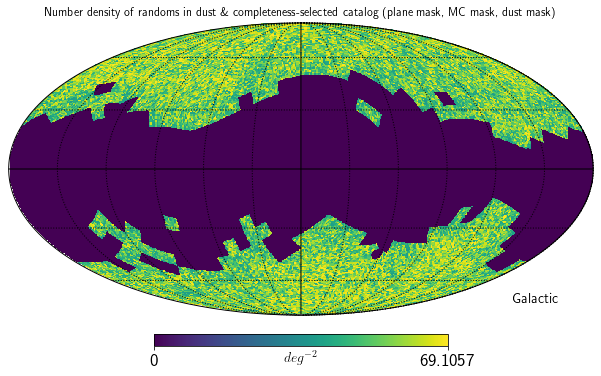

In [213]:
hp.mollview(
    map_nqso_rcompdust8planemcsAv/area_per_pixel,
    title=rf"Number density of randoms in dust \& completeness-selected catalog (plane mask, MC mask, dust mask)",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

## w(theta) for different randoms / masks

In [75]:
wtheta_rcomp_log = correlations.compute_wtheta(theta_edges_log, ra_data, dec_data,
                                                tab_rcomp['ra'], tab_rcomp['dec'])

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 6.4391 s
Time: 10.6010 s
Time: 5.5570 s


In [77]:
wtheta_rcompdust_log = correlations.compute_wtheta(theta_edges_log, ra_data, dec_data,
                                                tab_rcompdust['ra'], tab_rcompdust['dec'])

Time: 6.5330 s
Time: 13.3991 s
Time: 6.8261 s


Where we mask things in the random, we must also do so in the data:

In [82]:
wtheta_rcompdustplane_log = correlations.compute_wtheta(theta_edges_log, ra_data_plane, dec_data_plane,
                                                tab_rcompdustplane['ra'], tab_rcompdustplane['dec'])

Time: 6.2549 s
Time: 12.8299 s
Time: 6.6270 s


In [100]:
wtheta_rcompdustplanemcs_log = correlations.compute_wtheta(theta_edges_log, ra_data_planemcs, dec_data_planemcs,
                                                tab_rcompdustplanemcs['ra'], tab_rcompdustplanemcs['dec'])

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 6.3954 s
Time: 13.1084 s
Time: 6.7223 s


In [130]:
wtheta_rcompdustplanemcsAv_log = correlations.compute_wtheta(theta_edges_log, ra_data_planemcsAv, dec_data_planemcsAv,
                                                tab_rcompdustplanemcsAv['ra'], tab_rcompdustplanemcsAv['dec'])

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 4.7101 s
Time: 13.6757 s
Time: 10.0367 s


In [ ]:
wtheta_rcompdust8planemcsAv_log = correlations.compute_wtheta(theta_edges_log, ra_data_planemcsAv, dec_data_planemcsAv,
                                                tab_rcompdust8planemcsAv['ra'], tab_rcompdust8planemcsAv['dec'])

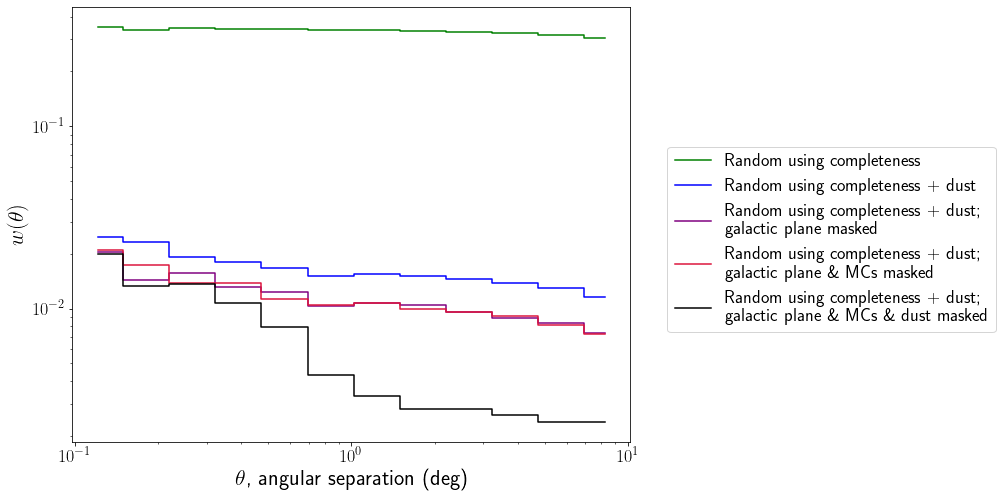

In [131]:
plt.figure(figsize=(10,8))
plt.step(theta_avg_log, wtheta_rcomp_log, where='mid', color='green',
         label=f'Random using completeness')
plt.step(theta_avg_log, wtheta_rcompdust_log, where='mid', color='blue',
         label=f'Random using completeness + dust')
plt.step(theta_avg_log, wtheta_rcompdustplane_log, where='mid', color='purple',
         label=f'Random using completeness + dust;\n galactic plane masked')
plt.step(theta_avg_log, wtheta_rcompdustplanemcs_log, where='mid', color='crimson',
         label=f'Random using completeness + dust;\n galactic plane \& MCs masked')
plt.step(theta_avg_log, wtheta_rcompdustplanemcsAv_log, where='mid', color='black',
         label=f'Random using completeness + dust;\n galactic plane \& MCs \& dust masked')
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
plt.yscale('log')
plt.axhline(0, color='grey', lw=0.8)
plt.legend(bbox_to_anchor=(1.05, 0.7))

TODO: plot min and max separation, and mean separation, in pixel